In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install moviepy -q

from moviepy.editor import VideoFileClip, ImageSequenceClip, AudioFileClip, AudioClip
from tensorflow.image import resize
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

In [3]:
# Ground Truth file path
csv_file_path = "/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv"
df = pd.read_csv(csv_file_path)
df.head(10)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"
5,21,"Push 'em out, push 'em out, harder, harder.",Joey,joy,positive,1,2,1,23,"00:10:46,979","00:10:50,148"
6,22,"Push 'em out, push 'em out, way out!",Joey,joy,positive,1,3,1,23,"00:10:50,316","00:10:52,609"
7,23,"Let's get that ball and really move, hey, hey,...",Joey,joy,positive,1,4,1,23,"00:10:52,777","00:10:55,612"
8,24,"Let's I was justyeah, right.",Joey,joy,positive,1,5,1,23,"00:10:55,780","00:11:01,242"
9,25,Push!,Joey,joy,positive,1,6,1,23,"0:11:01,410","0:11:01,828"


In [4]:
df.shape

(2610, 11)

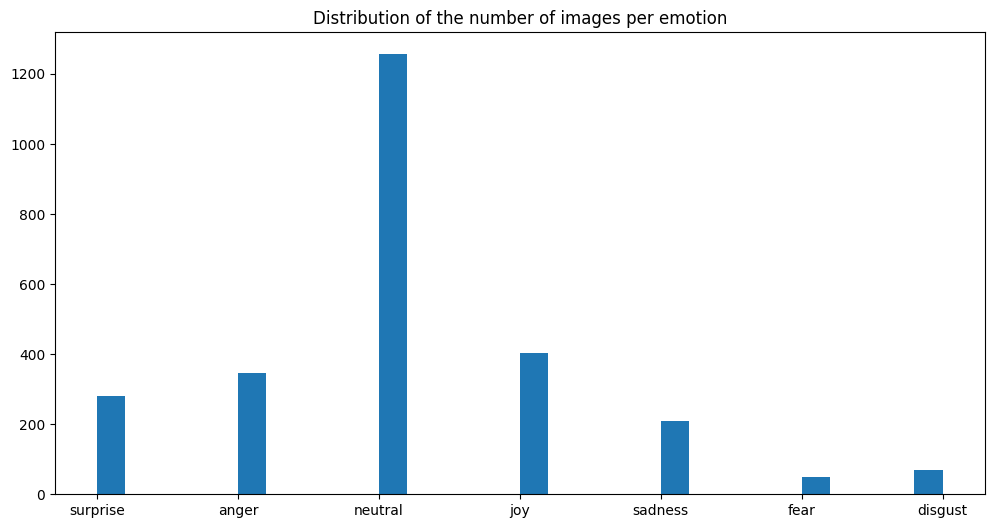

In [5]:
plt.figure(figsize=(12,6))
plt.hist(df['Emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

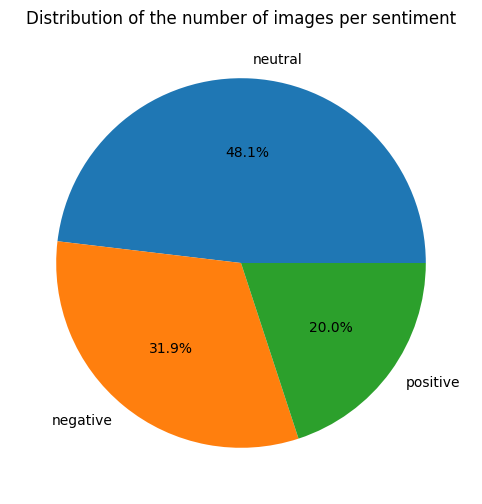

In [6]:
# First, count occurrences of each sentiment category
sentiment_counts = df['Sentiment'].value_counts()

# Plot pie chart with sentiment counts
plt.figure(figsize=(12, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title("Distribution of the number of images per sentiment")
plt.show()

In [7]:

# Resize frames and convert to grayscale
def preprocess_grayscale_video(video_path, num_frames=10):
    # Load video
    clip = VideoFileClip(video_path)                 
    video_fps = clip.fps
    video_frames = []

    # Extract frames at regular intervals
    total_frames = int(clip.duration * video_fps)
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i, frame in enumerate(clip.iter_frames()):
        if i in frame_indices:
            # Convert frame to grayscale by averaging the color channels
            grayscale_frame = np.mean(frame, axis=-1)
            # Add a channel dimension (since it's grayscale)
            grayscale_frame = np.expand_dims(grayscale_frame, axis=-1)
            # Resize to 299x299 to fit Xception input requirements
            resized_frame = tf.image.resize(grayscale_frame, [299, 299])
            video_frames.append(resized_frame)

    # Stack the frames to form a video representation
    return np.array(video_frames)


In [8]:
def create_dataset(video_directory, df, num_videos_to_process=100, num_frames=10):
    X = []
    y = []
    video_files = [file for file in os.listdir(video_directory) if file.endswith('.mp4') and not file.startswith('.')]
    video_files.sort()

    # Process videos one by one
    for video_file in video_files[:num_videos_to_process]:
        video_path = os.path.join(video_directory, video_file)

        try:
            # Extract Dialogue_ID and Utterance_ID from the file name
            components = video_file.strip('.mp4').split('_')
            
            if len(components) < 2 or not components[0][3:].isdigit() or not components[1][3:].isdigit():
                raise ValueError(f"Invalid file name format: {video_file}")
                
            dialogue_id, utterance_id = int(components[0][3:]), int(components[1][3:])
            
            # Find the corresponding label in the CSV
            filtered_row = df[(df["Dialogue_ID"] == dialogue_id) & (df["Utterance_ID"] == utterance_id)]
            if not filtered_row.empty:
                true_label = filtered_row["Emotion_Encoded"].values[0]

                # Preprocess the video
                video_data = preprocess_grayscale_video(video_path, num_frames=num_frames)
                if video_data is not None and video_data.shape == (num_frames, 299, 299, 1):
                    X.append(video_data)
                    y.append(true_label)
                    #print(f"Processed video: {video_file}, X shape: {video_data.shape}, Label: {label_encoder.inverse_transform([true_label])[0]}")
                else:
                    print(f"Skipping video {video_file}: Incomplete frames ({video_data.shape[0]} frames instead of {num_frames}).")
                
        except ValueError as e:
            print(f"Error processing video {video_file}: {e}")
        except Exception as e:
            print(f"Unexpected error processing video {video_file}: {e}")
    
    # Convert lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y


In [9]:
# Encode the emotion labels as numbers
label_encoder = LabelEncoder()
df['Emotion_Encoded'] = label_encoder.fit_transform(df['Emotion'])

df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Emotion_Encoded
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",6
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",0
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",4
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",4
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",3


In [10]:
# Directory containing video files
video_directory = '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test/output_repeated_splits_test'

# Create the dataset
X, y = create_dataset(video_directory, df, num_videos_to_process=4790, num_frames=10)

# Check the shapes of the dataset
print(f"X shape: {X.shape}, y shape: {y.shape}")


Error processing video dia100_utt4.mp4: Invalid file name format: dia100_utt4.mp4
Skipping video dia100_utt8.mp4: Incomplete frames (6 frames instead of 10).
Error processing video dia102_utt4.mp4: Invalid file name format: dia102_utt4.mp4
Error processing video dia103_utt4.mp4: Invalid file name format: dia103_utt4.mp4
Error processing video dia107_utt4.mp4: Invalid file name format: dia107_utt4.mp4
Error processing video dia108_utt4.mp4: Invalid file name format: dia108_utt4.mp4
Error processing video dia109_utt4.mp4: Invalid file name format: dia109_utt4.mp4
Error processing video dia110_utt4.mp4: Invalid file name format: dia110_utt4.mp4
Error processing video dia111_utt4.mp4: Invalid file name format: dia111_utt4.mp4
Error processing video dia112_utt4.mp4: Invalid file name format: dia112_utt4.mp4
Error processing video dia113_utt4.mp4: Invalid file name format: dia113_utt4.mp4
Error processing video dia114_utt4.mp4: Invalid file name format: dia114_utt4.mp4
Error processing video

In [11]:

np.save('X.npy', X)  # Save X to a .npy file
np.save('y.npy', y)  # Save y to a .npy file


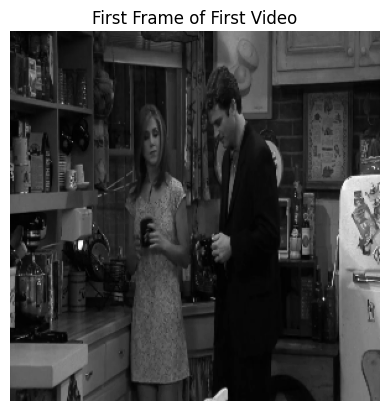

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X is your dataset and has been defined
# X[0] gives us the first sample with shape (10, 299, 299, 1)

# Select the first sample (first video) and the first frame
first_video = X[0]  # Shape: (10, 299, 299, 1)

# Display the first frame
first_frame = first_video[0]  # Shape: (299, 299, 1)

# Since it's a grayscale image, squeeze the last dimension to make it (299, 299)
first_frame = np.squeeze(first_frame)  # Shape: (299, 299)

# Plot the first frame
plt.imshow(first_frame, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('First Frame of First Video')
plt.axis('off')  # Hide axis
plt.show()
